In [1]:
%matplotlib inline

In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

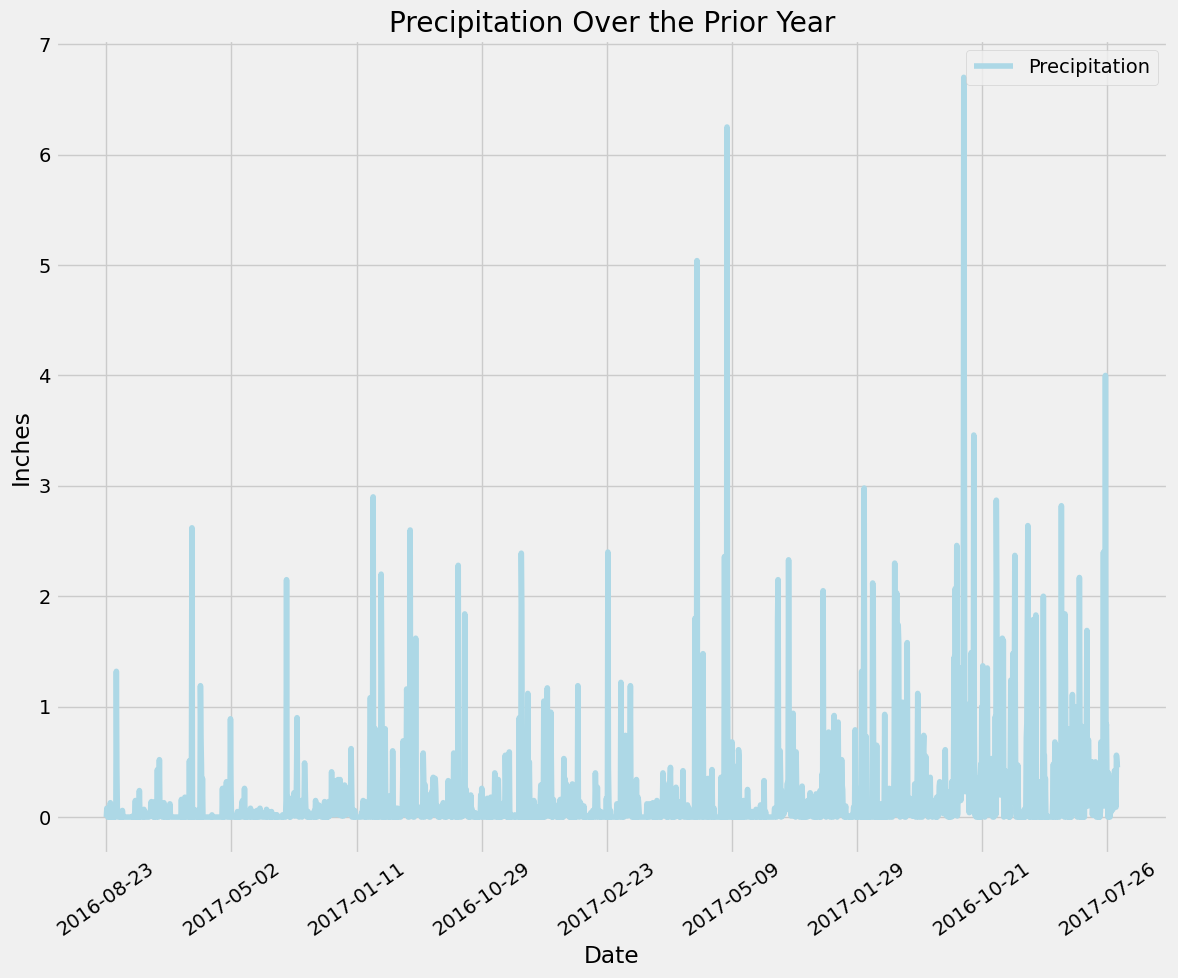

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. Calculate the date one year from the last date in data set.
dt_year_prior = ((dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d'))


# Perform a query to retrieve the data and precipitation scores
year_prior_data  = (session.query(measurement.date, measurement.prcp).filter(measurement.date >= dt_year_prior).all()) 

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(year_prior_data, columns=["Date","Precipitation"]).set_index('Date').dropna()
precipitation_df

# Sort the dataframe by date
precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(color = 'lightblue', figsize = (12,10), rot = 35)
plt.ylabel('Inches')
plt.title('Precipitation Over the Prior Year')
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(station).count()
stations

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.\
                    query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()

active_stations 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = active_stations[0][0]

most_active_data = (session
             .query(measurement.station,func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))
             .filter(measurement.station == most_active_id)
             .all())
most_active_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

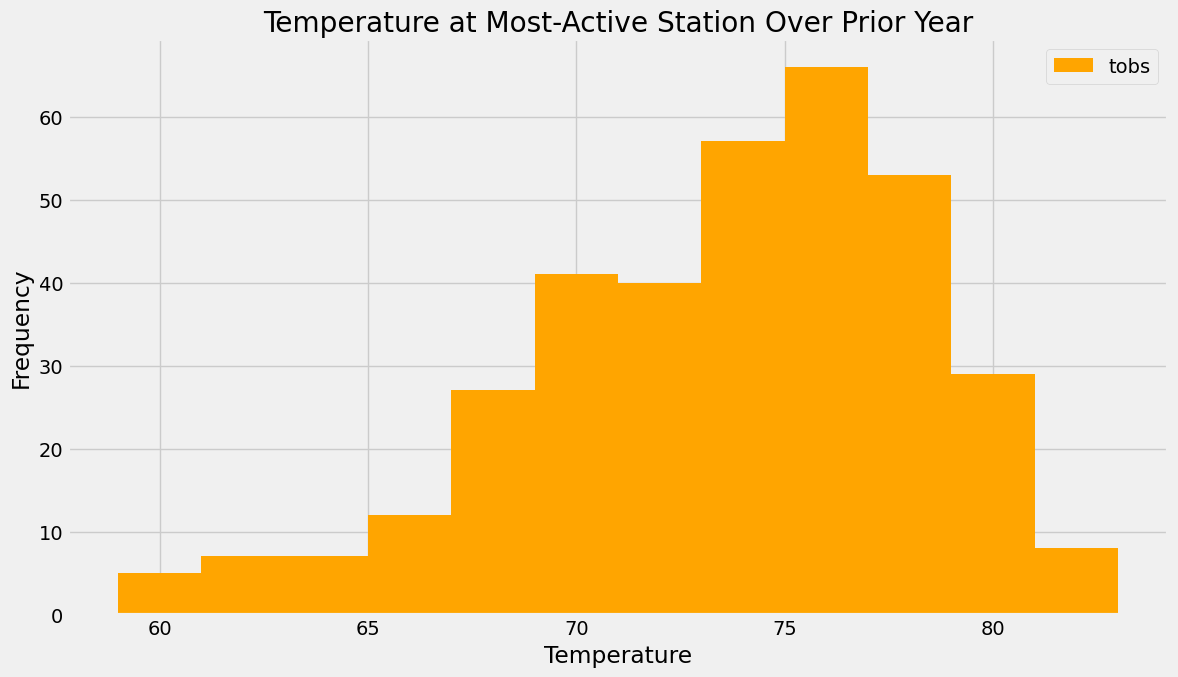

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
most_active_prior_year = (session
             .query(measurement.station, measurement.tobs)
             .filter(measurement.date >= dt_year_prior)
             .filter(measurement.station == most_active_id)
             .all())

most_active_df = pd.DataFrame(most_active_prior_year)

#and plot the results as a histogram
most_active_df.plot.hist(figsize = (12,7), color = 'orange', bins=12, legend=True)
plt.xlabel('Temperature')
plt.title('Temperature at Most-Active Station Over Prior Year')
plt.tight_layout()
plt.show()

# Close session

In [17]:
# Close Session
session.close()